# Building a recommender system on the Movie Lens dataset 3 - Training the Recommender System

**Subject** - Hired by a Parisian cinema, you want to recommend VOD movies to the clients based on what they went to see during the week. What do you recommend for someone who just saw Inferno, by Ron Howard ?

**Data** - First start by downloading the MovieLens 20M Dataset (https://grouplens.org/datasets/movielens/) and place the files into your project directory, in a subdirectory named 'data'

**This notebook focuses on building the recommender system itself**

The ideas explored here are mainly based on the article by Koren and Bell called *Advances in Collaborative Filtering*, taken from the *Recommender System Handbook, 2015*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
project_dir = 'YOUR_PROJECT_DIRECTORY'
df_um_matrix_train = pd.read_csv(project_dir+'data/um_matrix_train.csv', encoding = 'utf-8', delimiter=',', index_col = 'userId')
df_um_matrix_test = pd.read_csv(project_dir+'data/um_matrix_test.csv', encoding = 'utf-8', delimiter=',', index_col = 'userId')
user_ids = df_um_matrix_train.index.values.tolist()
movie_ids = df_um_matrix_train.columns.values.tolist()

In [3]:
df_um_matrix_train.head()

,1,2,3,4,5,6,7,8,9,10,...,106916,106920,108932,109374,109487,110102,111362,111759,112556,112852
userId,,,,,,,,,,,,,,,,,,,,,
31,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
34,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,3.0,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate the baseline predictors

**Definition** - 
CF models try to capture the interactions between users and items that produce the different rating values. However, much of the observed rating values are due to effects associated with either users or items, independently of their interaction. These effects are what baseline predictors (aka *biases*) try to capture.

In [4]:
mean_rating = np.mean(np.mean(df_um_matrix_train)) # 3.42
mean_user_rating = np.mean(df_um_matrix_train, axis = 1)
mean_movie_rating = np.mean(df_um_matrix_train, axis = 0)
print(mean_movie_rating)

In [6]:
print(int(mean_user_rating.isnull().sum()/len(mean_user_rating)*100), 
      '% of the users have rated none the movies selected in the restricted dataset')
print(int(mean_movie_rating.isnull().sum()/len(mean_movie_rating)*100), 
      '% of the movies have not been rated by any user in the restricted dataset')

0 % of the users have rated none the movies selected in the restricted dataset
0 % of the movies have not been rated by any user in the restricted dataset


In [7]:
# Filter out the movies that were not rated by any user in the dataset
#null_movies_index = mean_movie_rating.index[mean_movie_rating.isnull()].tolist()
#cols_to_keep = (~red_um_matrix.columns.isin(null_movies_index)).tolist()
#cols_to_keep = (red_um_matrix.columns[cols_to_keep]).tolist()
#red_um_matrix = red_um_matrix[cols_to_keep]
#movie_ids = [mov for mov in movie_ids if mov in cols_to_keep]
#mean_movie_rating = mean_movie_rating[~mean_movie_rating.isnull()]

In [8]:
# Calculate the baseline predictions for all movies - we take the user and movie deviations from
# the general mean of the dataset
user_biases = mean_user_rating - mean_rating
movie_biases = mean_movie_rating - mean_rating
user_biases_matrix = np.dot(user_biases.values.reshape(user_biases.shape[0], 1), np.ones((1,movie_biases.shape[0])))
movie_biases_matrix = np.dot(np.ones((user_biases.shape[0], 1)), movie_biases.values.reshape(1, movie_biases.shape[0]))
baseline_prediction = mean_rating + user_biases_matrix + movie_biases_matrix

## Neighborhood approach - Calculate the movie similarity matrix

We build a first predictor based on a neighborhood approach : we define a similarity measure between users (or items), and use the known evaluations of similar users to predict unknown evaluations. 

This approach can be applied in a user-user similarity maneer (use the ratings of similar users to predict a test user's ratings), or based on item-item similarity (use the ratings of the test user on items that are similar to predict unknown items)

Item-item has proven more efficient than user-user neighborhood approaches *(Koren and Bell, 2015)*. Therefore, we start with this approach.

In [10]:
um_matrix_train = df_um_matrix_train.as_matrix()
residuals_matrix = um_matrix_train - baseline_prediction
residuals_matrix[np.isnan(residuals_matrix)] = 0

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [12]:
scalar_prod = np.dot(residuals_matrix.T, residuals_matrix)
movie_norms = np.sqrt(np.diag(scalar_prod))
norm_prod = np.outer(movie_norms, movie_norms)

In [13]:
pearson_matrix = np.divide(scalar_prod, norm_prod)

In [15]:
ind_matrix = (residuals_matrix != 0)*1
common_users_matrix = np.matmul(ind_matrix.T, ind_matrix)

In [16]:
lambd = 5
shrinkage_coeff_matrix = np.divide(common_users_matrix - 1, common_users_matrix - 1 + lambd)

In [17]:
movie_sim_matrix = np.multiply(shrinkage_coeff_matrix, pearson_matrix)

In [18]:
movie_sim_matrix = pd.DataFrame(movie_sim_matrix)
movie_sim_matrix.index = movie_ids
movie_sim_matrix.columns = movie_ids
movie_sim_matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,106916,106920,108932,109374,109487,110102,111362,111759,112556,112852
1,0.997359,0.066453,0.012566,-0.018640,0.001878,-0.012718,-0.010180,-0.009429,-0.031025,0.018364,...,-0.011983,0.006207,0.011258,0.000034,0.014523,0.049030,0.044985,0.003523,0.003113,0.000134
2,0.066453,0.993880,0.020180,0.021174,0.045816,-0.008419,0.006149,0.015225,0.023057,0.023409,...,-0.020092,0.004049,0.022394,0.011343,0.003178,0.011187,0.013228,0.011956,0.012716,-0.006250
3,0.012566,0.020180,0.989540,0.015221,0.102209,-0.019541,0.061030,-0.008827,-0.006807,0.023582,...,0.003620,0.001332,0.003490,-0.000135,0.002218,-0.003630,-0.000481,0.001543,-0.000958,-0.000373
4,-0.018640,0.021174,0.015221,0.951456,0.018908,0.026711,0.027801,0.036798,-0.000226,-0.006480,...,-0.001709,-0.000128,-0.001738,0.001416,-0.000367,-0.000000,-0.000368,0.000297,-0.000048,-0.000740
5,0.001878,0.045816,0.102209,0.018908,0.989154,-0.025262,0.097306,0.050785,0.025834,0.035151,...,-0.001905,0.000335,-0.004418,-0.000577,-0.015004,0.001040,0.000963,-0.002379,-0.013591,-0.002957


## Generate predictions over the dataset

Since we do not know much about the user we are trying to help, ratings predictions are going to be close to the baseline predictions. However, we are going to use the only information we have about this user : that he saw Inferno. 

**Hypothesis** : We consider the target user as a mean user of the group of users who rated both Da Vinci Code and Angels and Demons (this group contains 40 people). We imput the ratings for 200 randomly chose movies, based on this hypothesis. This enables us to solve the **Cold Start** problem we have (no info about the target user), and feed our model for rating prediction.

*Reference* : http://www.yusp.com/blog/cold-start-problem-recommender-systems/

**Imput the ratings**

In [19]:
df_movies = pd.read_csv('data/movies_cleaned.csv', encoding='utf-8', sep=',')
da_vinci_titles = [mov for mov in df_movies['title'] if 'Da Vinci' in mov]
print(da_vinci_titles)
angels_and_demons_titles = [mov for mov in df_movies['title'] if 'Angels' in mov and 'Demons' in mov]
print(angels_and_demons_titles)
df_movies.loc[df_movies['title'].isin(da_vinci_titles + angels_and_demons_titles)]

['Da Vinci Code, The (2006)']
['Angels & Demons (2009)']


,movieId,title,year,genre_IMAX,genre_Children,genre_Romance,genre_Fantasy,genre_Documentary,genre_Musical,genre_Adventure,...,genre_War,genre_Drama,genre_Western,genre_Film-Noir,genre_Animation,genre_Comedy,genre_Mystery,genre_Action,genre_Sci-Fi,genre_Thriller
11019,45447,"Da Vinci Code, The (2006)",2006.0,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,True
13713,68554,Angels & Demons (2009),2009.0,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,True


In [20]:
da_vinci_id = 45447
angels_demons_id = 68554

In [21]:
np.random.seed(1)
movies_to_imput = np.random.choice(movie_ids, 500, replace=False)
inferno_users_subset_ratings = df_um_matrix_train[~np.isnan(df_um_matrix_train[str(da_vinci_id)]) & ~np.isnan(df_um_matrix_train[str(angels_demons_id)])]
mean_inferno_users_ratings = np.nanmean(inferno_users_subset_ratings, axis = 0)
mean_inferno_users_ratings = mean_inferno_users_ratings.reshape(1, 3000)
target_user_ratings = pd.DataFrame(mean_inferno_users_ratings, 
                                   columns=inferno_users_subset_ratings.columns)
target_user_ratings[[col for col in inferno_users_subset_ratings.columns if not col in movies_to_imput]] = np.nan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


Number of ratings imputed to target user :  496
Number of movies not rated by target user :  2504


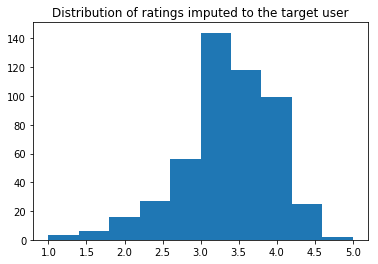

In [22]:
print('Number of ratings imputed to target user : ', np.sum(~np.isnan(mean_inferno_users_ratings)))
print('Number of movies not rated by target user : ', np.sum(np.isnan(mean_inferno_users_ratings)))
tu_ratings = target_user_ratings.values[~np.isnan(target_user_ratings.values)]
plt.hist(tu_ratings)
plt.title('Distribution of ratings imputed to the target user')
plt.show()

**Calculate the target user baseline prediction and residuals on known ratings**

In [24]:
target_user_mean_rating = np.nanmean(target_user_ratings)
target_user_deviation = target_user_mean_rating - mean_rating
movies_deviation = mean_movie_rating - mean_rating
target_user_baseline_prediction = mean_rating + target_user_deviation + movies_deviation

In [25]:
target_user_residuals = target_user_ratings - target_user_baseline_prediction

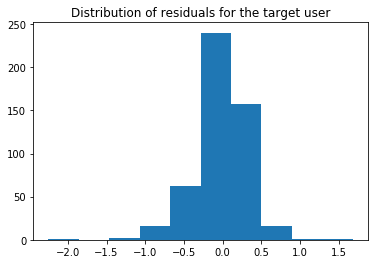

In [26]:
tu_residuals = target_user_residuals.values[~np.isnan(target_user_residuals.values)]
plt.hist(tu_residuals)
plt.title('Distribution of residuals for the target user')
plt.show()

Now that we have residuals for our cinema client, we can predict the ratings he would give to all the movies in our dataset.

**Evaluate residual term for all missing movies**

In [34]:
missing_movies = target_user_ratings.columns[np.isnan(target_user_ratings.values)[0]]

In [41]:
res_terms = np.zeros((1, len(missing_movies)))
k = 50
for i, mov in enumerate(missing_movies):
    sim_column = movie_sim_matrix[mov]
    k_neighbors = sim_column.nlargest(k)
    rated_neighbors = [m for m in k_neighbors.index.values.tolist() if m not in missing_movies]
    if len(rated_neighbors)>0 :
        k_neighbors_sim = k_neighbors.loc[rated_neighbors].sort_index()
        k_neighbors_residuals = target_user_residuals[rated_neighbors].iloc[0].sort_index()
        res_terms[0,i] = np.average(k_neighbors_residuals.values, weights=k_neighbors_sim.values)   
res_terms = pd.Series(data=res_terms.reshape(res_terms.shape[1]), index=missing_movies)

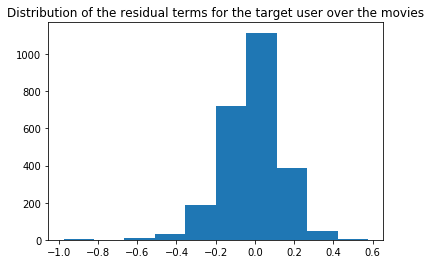

In [42]:
plt.hist(res_terms)
plt.title('Distribution of the residual terms for the target user over the movies')
plt.show()

**Evaluate the rating prediction for all missing movies**

In [43]:
missing_movies_baseline_prediction = target_user_baseline_prediction.loc[missing_movies]
missing_movies_res_term = res_terms.loc[missing_movies]
missing_movies_prediction = missing_movies_baseline_prediction + missing_movies_res_term

In [33]:
movies_info = df_movies[df_movies['movieId'].isin(missing_movies)]
movies_info.index = movies_info['movieId'].astype('str')
cols_to_drop = [col for col in movies_info.columns if 'genre_' in col]
cols_to_drop.append('movieId')
movies_info = movies_info.drop(columns = cols_to_drop)
movies_info = movies_info.loc[missing_movies]
inferno_sim = (movie_sim_matrix[str(da_vinci_id)] + movie_sim_matrix[str(angels_demons_id)])/2
inferno_sim = inferno_sim.loc[missing_movies]
pred_results = movies_info.join([pd.DataFrame({'pred':missing_movies_prediction}), 
                  pd.DataFrame({'base_pred':missing_movies_baseline_prediction}),
                  pd.DataFrame({'res_term':missing_movies_res_term}),
                  pd.DataFrame({'movie_sim' : inferno_sim})])
pred_results.head()

,title,year,pred,base_pred,res_term,movie_sim
1,Toy Story (1995),1995.0,3.870657,3.832295,0.038362,-0.014755
2,Jumanji (1995),1995.0,3.235592,3.213141,0.022451,-0.007544
3,Grumpier Old Men (1995),1995.0,3.064323,3.071324,-0.007001,-0.004687
6,Heat (1995),1995.0,3.875986,3.729869,0.146117,-0.008436
8,Tom and Huck (1995),1995.0,3.191331,3.282084,-0.090752,-0.000046


## Recommend best movies for target user

Now that we predicted the ratings over the dataset, we can recommend the best-suited movies for our target user.

**Pure Rating Prediction Recommendation**

In [63]:
pred_results.sort_values('pred', ascending = False).head(10)

,title,year,pred,base_pred,res_term,movie_sim
5008,Witness for the Prosecution (1957),1957.0,4.550629,4.276911,0.273718,-0.001993
945,Top Hat (1935),1935.0,4.484686,4.133576,0.351110,0.003213
1248,Touch of Evil (1958),1958.0,4.457850,4.248175,0.209674,-0.009979
930,Notorious (1946),1946.0,4.423788,4.202198,0.221590,-0.014132
6669,Ikiru (1952),1952.0,4.413125,4.360655,0.052470,0.011524
318,"Shawshank Redemption, The (1994)",1994.0,4.391347,4.402285,-0.010938,0.022543
5291,Rashomon (Rashômon) (1950),1950.0,4.382663,4.200084,0.182579,-0.018869
1284,"Big Sleep, The (1946)",1946.0,4.355210,4.186938,0.168272,0.003519
50,"Usual Suspects, The (1995)",1995.0,4.351168,4.270610,0.080559,0.016020
922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),1950.0,4.335723,4.085930,0.249793,-0.015302


**Comment** : it seems that on average, the best rated movies in the dataset are old movies, giving much weight to them in the recommendation (through the baseline prediction). Let us check this observation...

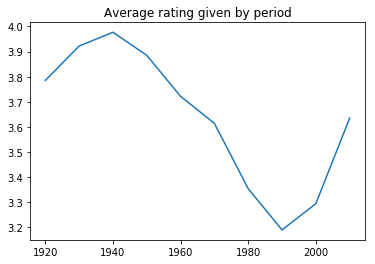

In [78]:
pred_results['period'] = np.divmod(pred_results['year'] - 1900, 10)[0]*10 + 1900
plot_data = pred_results[['period', 'pred']].groupby('period').mean()
x = plot_data.index.astype('float').tolist()
y = plot_data['pred'].values.tolist()
plt.plot(x, y)
plt.title('Average rating given by period')
plt.show()

Indeed, the average rating given to movies from the 1940's is close to 4, while the rating for 1990's movies is around 3.2... This creates a bias in the recommendations provided by the system toward old movies. 

From a user experience perspective, we do not want to recommend exclusively old movies, so let us look at what the recommendations would be for movies that are more recent.

**Prediction by period**

In [90]:
recommendation = pd.DataFrame()
for p in np.unique(pred_results['period']):
    pred_subset = pred_results[pred_results['period'] == p]
    period_reco = pred_subset.nlargest(columns='pred', n=5)
    recommendation = pd.concat([recommendation, period_reco])

In [94]:
recommendation[recommendation['period'] == 2010]

,title,year,pred,base_pred,res_term,movie_sim,period
79132,Inception (2010),2010.0,4.131333,4.096146,0.035187,0.014830,2010.0
112556,Gone Girl (2014),2014.0,4.106919,4.125961,-0.019042,0.034954,2010.0
92259,Intouchables (2011),2011.0,4.089896,4.142868,-0.052972,0.002422,2010.0
78499,Toy Story 3 (2010),2010.0,4.069860,3.934511,0.135349,-0.010019,2010.0
109487,Interstellar (2014),2014.0,4.040930,4.016699,0.024231,0.017037,2010.0


The predictions are better, though the baseline_predictors have much weight in the final outcome, giving a bias toward generally liked movies, but not very specific to the current user. Let us look at the similarity measure of the movies with Da Vinci Code and Anges & Demons, to get more user-specific recommendations.

**Prediction by movie similarity**

In [98]:
pred_results.sort_values('movie_sim', ascending = False).head(7)

,title,year,pred,base_pred,res_term,movie_sim,period
45447,"Da Vinci Code, The (2006)",2006.0,3.020216,3.053845,-0.033629,0.548396,2000.0
68554,Angels & Demons (2009),2009.0,2.876683,3.022993,-0.146309,0.525373,2000.0
8972,National Treasure (2004),2004.0,3.411054,3.422343,-0.011290,0.113777,2000.0
8984,Ocean's Twelve (2004),2004.0,3.244278,3.233031,0.011247,0.107404,2000.0
63876,Milk (2008),2008.0,3.729055,3.894040,-0.164986,0.099949,2000.0
31696,Constantine (2005),2005.0,3.276274,3.153560,0.122714,0.087974,2000.0
59369,Taken (2008),2008.0,3.684909,3.723975,-0.039066,0.087020,2000.0


As expected, Da Vinci Code and Angels & Demons are the movies with highest similarity to Inferno (since we constructed the Inferno similarity through those two). The movies that are then found most similar to Inferno in the dataset are recent movies, rather in the genre "Action", which is consistent with what we know of Inferno.

However, some of these movies do not have a very good baseline rating (3.23 for Ocean's Twelve for example, which is below the average of the dataset) so the estimated prediction is not so high.

## Conclusion for the recommendation part

Finally the ranking by pure movie similarity seems quite ok, given the fact that we know very little about the user. We could implement and present several kinds of rankings, for example :

- *"Users who liked Inferno also liked..."*, based on the movie similarity measure
- *"Best Rated movies for you"* based on the rating predictions, including movies from several periods
- *"Best 1940's Movies for you"*, breaking the recommendation by period.

Choosing the best way to present the results is then based on user experience, that can be investigated through AB testing for example.